In [1]:
# ===========================
# Cell 1: 導入套件和設定
# ===========================
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import os
import time
import joblib
import json
from collections import Counter
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    confusion_matrix, balanced_accuracy_score, 
    cohen_kappa_score
)

# Boosting模型
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# 檢查環境
print("環境檢查:")
print(f"XGBoost: {xgb.__version__}")
print(f"LightGBM: {lgb.__version__}")

環境檢查:
XGBoost: 3.0.2
LightGBM: 4.3.0


In [2]:
# ===========================
# Cell 2: 載入資料（簡化版）
# ===========================
print("\n載入資料...")
file_path = 'us-accidents/US_Accidents_March23.csv'

# 直接載入所有數值和類別特徵
df = pd.read_csv(file_path)
print(f"原始資料大小: {df.shape}")

# 顯示目標變數分布
print("\n目標變數分布:")
severity_counts = df['Severity'].value_counts().sort_index()
for sev, count in severity_counts.items():
    print(f"Severity {sev}: {count:,} ({count/len(df)*100:.2f}%)")


載入資料...
原始資料大小: (7728394, 46)

目標變數分布:
Severity 1: 67,366 (0.87%)
Severity 2: 6,156,981 (79.67%)
Severity 3: 1,299,337 (16.81%)
Severity 4: 204,710 (2.65%)


In [3]:
# ===========================
# Cell 3: 特徵選擇和資料準備
# ===========================
print("\n準備特徵...")

# 選擇數值特徵（根據 Kaggle 最佳實踐）
numeric_features = [
    'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng',
    'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 
    'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
    'Wind_Speed(mph)', 'Precipitation(in)'
]

# 選擇布林特徵
boolean_features = [
    'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
    'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 
    'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop'
]

# 選擇類別特徵
categorical_features = [
    'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 
    'Astronomical_Twilight'
]

# 合併所有特徵
all_features = numeric_features + boolean_features + categorical_features

# 檢查哪些特徵存在
existing_features = [col for col in all_features if col in df.columns]
print(f"使用 {len(existing_features)} 個特徵")

# 準備特徵矩陣
X = df[existing_features].copy()

# 處理布林值
for col in boolean_features:
    if col in X.columns:
        X[col] = X[col].map({True: 1, False: 0})

# 處理類別特徵
for col in categorical_features:
    if col in X.columns:
        X[col] = pd.Categorical(X[col]).codes

# 填充缺失值
X = X.fillna(-999)  # XGBoost/LightGBM/CatBoost 都能處理這個特殊值

# 準備目標變數
y = df['Severity'].values - 1  # 轉換為 0-3

print(f"特徵矩陣大小: {X.shape}")


準備特徵...
使用 29 個特徵
特徵矩陣大小: (7728394, 29)


In [4]:
# ===========================
# Cell 4: 切分訓練集和測試集
# ===========================
print("\n切分資料集...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"訓練集大小: {X_train.shape}")
print(f"測試集大小: {X_test.shape}")

# 儲存特徵名稱
feature_names = X.columns.tolist()

# 創建輸出目錄
os.makedirs('./model_output', exist_ok=True)


切分資料集...
訓練集大小: (6182715, 29)
測試集大小: (1545679, 29)


In [6]:
# ===========================
# Cell 5: XGBoost 模型（Kaggle 最佳參數）
# ===========================
print("\n" + "="*60)
print("訓練 XGBoost 模型")
print("="*60)

xgb_params = {
    'objective': 'multi:softprob',
    'num_class': 4,
    'max_depth': 10,
    'learning_rate': 0.01,
    'n_estimators': 2000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 5,
    'gamma': 0.1,
    'reg_alpha': 0.01,
    'reg_lambda': 1,
    'tree_method': 'gpu_hist',  # 更快的方法
    'device': 'cuda',
    'random_state': 42,
    'eval_metric': 'mlogloss',
    'early_stopping_rounds': 100,
    'verbosity': 1
}

print("開始訓練 XGBoost...")
start_time = time.time()

xgb_model = xgb.XGBClassifier(**xgb_params)

# 訓練模型
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)

train_time = time.time() - start_time

# 預測
y_pred_xgb = xgb_model.predict(X_test)

# 評估
xgb_acc = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb, average='weighted')
xgb_balanced_acc = balanced_accuracy_score(y_test, y_pred_xgb)

print(f"\n訓練時間: {train_time/60:.2f} 分鐘")
print(f"最佳迭代次數: {xgb_model.best_iteration}")
print(f"準確率: {xgb_acc:.4f}")
print(f"F1分數: {xgb_f1:.4f}")
print(f"平衡準確率: {xgb_balanced_acc:.4f}")


訓練 XGBoost 模型
開始訓練 XGBoost...
[0]	validation_0-mlogloss:1.37273
[100]	validation_0-mlogloss:0.70211
[200]	validation_0-mlogloss:0.50444
[300]	validation_0-mlogloss:0.43175
[400]	validation_0-mlogloss:0.39943
[500]	validation_0-mlogloss:0.38177
[600]	validation_0-mlogloss:0.37023
[700]	validation_0-mlogloss:0.36229
[800]	validation_0-mlogloss:0.35655
[900]	validation_0-mlogloss:0.35246
[1000]	validation_0-mlogloss:0.34875
[1100]	validation_0-mlogloss:0.34568
[1200]	validation_0-mlogloss:0.34287
[1300]	validation_0-mlogloss:0.34032
[1400]	validation_0-mlogloss:0.33766
[1500]	validation_0-mlogloss:0.33537
[1600]	validation_0-mlogloss:0.33333
[1700]	validation_0-mlogloss:0.33135
[1800]	validation_0-mlogloss:0.32970
[1900]	validation_0-mlogloss:0.32815
[1999]	validation_0-mlogloss:0.32658

訓練時間: 3.97 分鐘
最佳迭代次數: 1999
準確率: 0.8734
F1分數: 0.8615
平衡準確率: 0.4784


In [ ]:
# ===========================
# Cell 6: CatBoost 模型（Kaggle 最佳參數）
# ===========================
print("\n" + "="*60)
print("訓練 CatBoost 模型")
print("="*60)

cat_params = {
    'iterations': 2000,
    'learning_rate': 0.03,
    'depth': 8,
    'l2_leaf_reg': 3,
    'bootstrap_type': 'Bayesian',
    # 'subsample': 0.8,
    'random_strength': 1,
    'bagging_temperature': 0.2,
    'od_type': 'Iter',
    'od_wait': 100,
    'loss_function': 'MultiClass',
    'eval_metric': 'TotalF1:average=Macro',
    'task_type': 'GPU',
    'devices': '0',
    'random_seed': 42,
    'verbose': 100,
    'auto_class_weights': 'Balanced'
}

print("開始訓練 CatBoost...")
start_time = time.time()

# 處理類別特徵索引
cat_features = []  # CatBoost 可以自動處理類別特徵

cat_model = CatBoostClassifier(**cat_params)
cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True,
    plot=False,
    cat_features=cat_features
)

train_time = time.time() - start_time

# 預測
y_pred_cat = cat_model.predict(X_test)

# 評估
cat_acc = accuracy_score(y_test, y_pred_cat)
cat_f1 = f1_score(y_test, y_pred_cat, average='weighted')
cat_balanced_acc = balanced_accuracy_score(y_test, y_pred_cat)

print(f"\n訓練時間: {train_time/60:.2f} 分鐘")
print(f"最佳迭代次數: {cat_model.best_iteration_}")
print(f"準確率: {cat_acc:.4f}")
print(f"F1分數: {cat_f1:.4f}")
print(f"平衡準確率: {cat_balanced_acc:.4f}")



訓練 CatBoost 模型
開始訓練 CatBoost...
0:	learn: 0.6443111	test: 0.6442859	best: 0.6442859 (0)	total: 158ms	remaining: 5m 14s
100:	learn: 0.6827517	test: 0.6828177	best: 0.6828177 (100)	total: 3.81s	remaining: 1m 11s
200:	learn: 0.7030146	test: 0.7031249	best: 0.7031249 (200)	total: 7.32s	remaining: 1m 5s
300:	learn: 0.7137199	test: 0.7134161	best: 0.7134161 (300)	total: 10.8s	remaining: 1m
400:	learn: 0.7215129	test: 0.7202955	best: 0.7202955 (400)	total: 14.1s	remaining: 56.4s
500:	learn: 0.7274005	test: 0.7257690	best: 0.7257690 (500)	total: 17.4s	remaining: 52.2s
600:	learn: 0.7319061	test: 0.7297467	best: 0.7298029 (598)	total: 20.8s	remaining: 48.4s
700:	learn: 0.7353527	test: 0.7326633	best: 0.7326633 (700)	total: 24.1s	remaining: 44.6s
800:	learn: 0.7388614	test: 0.7360017	best: 0.7360017 (800)	total: 27.4s	remaining: 41s
900:	learn: 0.7415233	test: 0.7386161	best: 0.7386161 (900)	total: 30.7s	remaining: 37.5s
1000:	learn: 0.7444568	test: 0.7410661	best: 0.7410661 (1000)	total: 34s	r

In [13]:
# ===========================
# Cell 7: LightGBM 模型（Kaggle 最佳參數）
# ===========================
print("\n" + "="*60)
print("訓練 LightGBM 模型")
print("="*60)

lgb_params = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 255,
    'max_depth': -1,
    'learning_rate': 0.01,
    'n_estimators': 2000,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.01,
    'reg_lambda': 0.01,
    'min_split_gain': 0.01,
    'min_child_weight': 10,
    'min_child_samples': 20,
    'class_weight': 'balanced',
    'device': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'verbose': -1,
    'random_state': 42,
    'n_jobs': -1,
    'force_col_wise': True
}

print("開始訓練 LightGBM...")
start_time = time.time()

lgb_model = lgb.LGBMClassifier(**lgb_params)

# 使用 early stopping
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='multi_logloss',
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ]
)

train_time = time.time() - start_time

# 預測
y_pred_lgb = lgb_model.predict(X_test)

# 評估
lgb_acc = accuracy_score(y_test, y_pred_lgb)
lgb_f1 = f1_score(y_test, y_pred_lgb, average='weighted')
lgb_balanced_acc = balanced_accuracy_score(y_test, y_pred_lgb)

print(f"\n訓練時間: {train_time/60:.2f} 分鐘")
print(f"最佳迭代次數: {lgb_model.best_iteration_}")
print(f"準確率: {lgb_acc:.4f}")
print(f"F1分數: {lgb_f1:.4f}")
print(f"平衡準確率: {lgb_balanced_acc:.4f}")



訓練 LightGBM 模型
開始訓練 LightGBM...
Training until validation scores don't improve for 100 rounds
[100]	valid_0's multi_logloss: 0.993616
[200]	valid_0's multi_logloss: 0.900673
[300]	valid_0's multi_logloss: 0.853711
[400]	valid_0's multi_logloss: 0.822817
[500]	valid_0's multi_logloss: 0.802336
[600]	valid_0's multi_logloss: 0.789445
[700]	valid_0's multi_logloss: 0.780548
[800]	valid_0's multi_logloss: 0.772666
[900]	valid_0's multi_logloss: 0.765717
[1000]	valid_0's multi_logloss: 0.759312
[1100]	valid_0's multi_logloss: 0.753813
[1200]	valid_0's multi_logloss: 0.748766
[1300]	valid_0's multi_logloss: 0.743868
[1400]	valid_0's multi_logloss: 0.738996
[1500]	valid_0's multi_logloss: 0.734482
[1600]	valid_0's multi_logloss: 0.730155
[1700]	valid_0's multi_logloss: 0.726176
[1800]	valid_0's multi_logloss: 0.722007
[1900]	valid_0's multi_logloss: 0.718182
[2000]	valid_0's multi_logloss: 0.714609
Did not meet early stopping. Best iteration is:
[2000]	valid_0's multi_logloss: 0.714609

訓練時間

In [14]:
# ===========================
# Cell 8: 模型比較和視覺化
# ===========================
print("\n" + "="*80)
print("模型性能比較")
print("="*80)

# 收集結果
results = {
    'XGBoost': {
        'accuracy': xgb_acc,
        'f1': xgb_f1,
        'balanced_acc': xgb_balanced_acc,
        'model': xgb_model,
        'best_iteration': xgb_model.best_iteration
    },
    'CatBoost': {
        'accuracy': cat_acc,
        'f1': cat_f1,
        'balanced_acc': cat_balanced_acc,
        'model': cat_model,
        'best_iteration': cat_model.best_iteration_
    },
    'LightGBM': {
        'accuracy': lgb_acc,
        'f1': lgb_f1,
        'balanced_acc': lgb_balanced_acc,
        'model': lgb_model,
        'best_iteration': lgb_model.best_iteration_
    }
}

# 顯示比較表格
print(f"{'模型':<15} {'準確率':<10} {'F1分數':<10} {'平衡準確率':<12} {'最佳迭代':<10}")
print("-"*67)

# 按平衡準確率排序
sorted_results = sorted(results.items(), key=lambda x: x[1]['balanced_acc'], reverse=True)

for model_name, metrics in sorted_results:
    print(f"{model_name:<15} {metrics['accuracy']:<10.4f} {metrics['f1']:<10.4f} "
          f"{metrics['balanced_acc']:<12.4f} {metrics['best_iteration']:<10}")

# 找出最佳模型
best_model_name, best_metrics = sorted_results[0]
print(f"\n🏆 最佳模型: {best_model_name}")
print(f"   平衡準確率: {best_metrics['balanced_acc']:.4f}")

# 保存最佳模型
best_model = best_metrics['model']
joblib.dump(best_model, f'./model_output/best_model_{best_model_name.lower()}.pkl')
print(f"\n最佳模型已保存至: ./model_output/best_model_{best_model_name.lower()}.pkl")



模型性能比較
模型              準確率        F1分數       平衡準確率        最佳迭代      
-------------------------------------------------------------------
LightGBM        0.6725     0.7319     0.7917       2000      
CatBoost        0.6040     0.6734     0.7625       1999      
XGBoost         0.8734     0.8615     0.4784       1999      

🏆 最佳模型: LightGBM
   平衡準確率: 0.7917

最佳模型已保存至: ./model_output/best_model_lightgbm.pkl


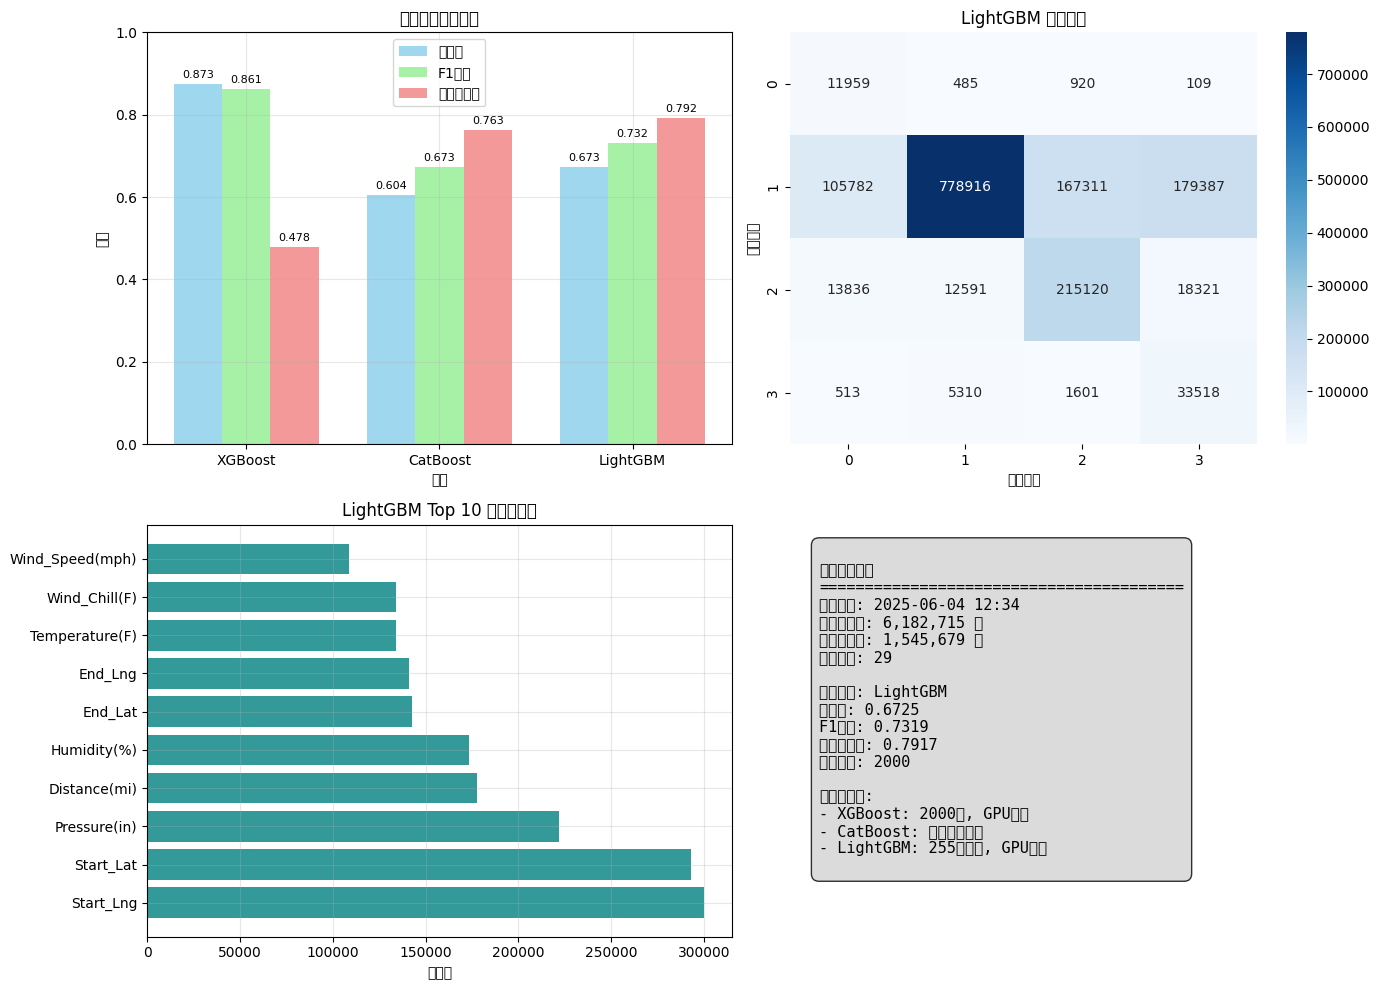

In [16]:
# ===========================
# Cell 9: 創建比較視覺化
# ===========================
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

model_names = list(results.keys())
accuracies = [results[m]['accuracy'] for m in model_names]
f1_scores = [results[m]['f1'] for m in model_names]
balanced_accs = [results[m]['balanced_acc'] for m in model_names]

# 子圖1: 性能指標比較
x = np.arange(len(model_names))
width = 0.25

bars1 = ax1.bar(x - width, accuracies, width, label='準確率', alpha=0.8, color='skyblue')
bars2 = ax1.bar(x, f1_scores, width, label='F1分數', alpha=0.8, color='lightgreen')
bars3 = ax1.bar(x + width, balanced_accs, width, label='平衡準確率', alpha=0.8, color='lightcoral')

ax1.set_xlabel('模型')
ax1.set_ylabel('分數')
ax1.set_title('模型性能指標比較')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)
ax1.legend()
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# 添加數值標籤
for i in range(len(model_names)):
    ax1.text(i - width, accuracies[i] + 0.01, f'{accuracies[i]:.3f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i, f1_scores[i] + 0.01, f'{f1_scores[i]:.3f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i + width, balanced_accs[i] + 0.01, f'{balanced_accs[i]:.3f}', ha='center', va='bottom', fontsize=8)

# 子圖2: 混淆矩陣（最佳模型）
if best_model_name == 'XGBoost':
    y_pred_best = y_pred_xgb
elif best_model_name == 'CatBoost':
    y_pred_best = y_pred_cat
else:
    y_pred_best = y_pred_lgb

cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2)
ax2.set_title(f'{best_model_name} 混淆矩陣')
ax2.set_xlabel('預測類別')
ax2.set_ylabel('實際類別')

# 子圖3: 特徵重要性（最佳模型）
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    top_features_idx = np.argsort(feature_importance)[-10:][::-1]
    top_features = [feature_names[i] for i in top_features_idx]
    top_importance = feature_importance[top_features_idx]
    
    ax3.barh(range(10), top_importance, color='teal', alpha=0.8)
    ax3.set_yticks(range(10))
    ax3.set_yticklabels(top_features)
    ax3.set_xlabel('重要性')
    ax3.set_title(f'{best_model_name} Top 10 特徵重要性')
    ax3.grid(True, alpha=0.3)
else:
    ax3.text(0.5, 0.5, '無特徵重要性資訊', ha='center', va='center', transform=ax3.transAxes)
    ax3.axis('off')

# 子圖4: 模型摘要
ax4.axis('off')
summary_text = f"""
模型訓練摘要
{'='*40}
訓練時間: {datetime.now().strftime('%Y-%m-%d %H:%M')}
訓練集大小: {len(X_train):,} 筆
測試集大小: {len(X_test):,} 筆
特徵數量: {len(feature_names)}

最佳模型: {best_model_name}
準確率: {best_metrics['accuracy']:.4f}
F1分數: {best_metrics['f1']:.4f}
平衡準確率: {best_metrics['balanced_acc']:.4f}
最佳迭代: {best_metrics['best_iteration']}

各模型特點:
- XGBoost: 2000輪, GPU加速
- CatBoost: 自動平衡權重
- LightGBM: 255葉節點, GPU優化
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('./model_output/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [17]:
# ===========================
# Cell 10: 準備 Kepler.gl 數據
# ===========================
def prepare_kepler_gl_data(model, sample_size=50000):
    """準備用於 Kepler.gl 的時空預測數據"""
    print("\n準備 Kepler.gl 時空視覺化數據...")
    
    # 重新載入包含地理位置和時間的數據
    print("載入地理和時間數據...")
    
    required_cols = [
        'Start_Lat', 'Start_Lng', 'Start_Time', 'End_Time',
        'Severity', 'State', 'City', 'Weather_Condition',
        'Temperature(F)', 'Visibility(mi)', 'Distance(mi)'
    ] + existing_features
    
    # 讀取數據
    df_kepler = pd.read_csv(
        file_path, 
        usecols=[col for col in required_cols if col in pd.read_csv(file_path, nrows=1).columns],
        nrows=sample_size * 2
    )
    
    print(f"載入數據大小: {df_kepler.shape}")
    
    # 處理時間
    df_kepler['Start_Time'] = pd.to_datetime(df_kepler['Start_Time'])
    df_kepler['End_Time'] = pd.to_datetime(df_kepler['End_Time'])
    
    # 刪除缺失值
    df_kepler = df_kepler.dropna(subset=['Start_Lat', 'Start_Lng', 'Start_Time'])
    
    # 限制數據量
    if len(df_kepler) > sample_size:
        df_kepler = df_kepler.sample(n=sample_size, random_state=42)
    
    print(f"處理後數據大小: {df_kepler.shape}")
    
    # 提取時間特徵
    df_kepler['hour'] = df_kepler['Start_Time'].dt.hour
    df_kepler['day_of_week'] = df_kepler['Start_Time'].dt.dayofweek
    df_kepler['month'] = df_kepler['Start_Time'].dt.month
    df_kepler['year'] = df_kepler['Start_Time'].dt.year
    
    # 計算事故持續時間
    df_kepler['duration_minutes'] = (
        df_kepler['End_Time'] - df_kepler['Start_Time']
    ).dt.total_seconds() / 60
    
    # 準備預測特徵
    X_kepler = df_kepler[existing_features].copy()
    
    # 處理布林值
    for col in boolean_features:
        if col in X_kepler.columns:
            X_kepler[col] = X_kepler[col].map({True: 1, False: 0})
    
    # 處理類別特徵
    for col in categorical_features:
        if col in X_kepler.columns:
            X_kepler[col] = pd.Categorical(X_kepler[col]).codes
    
    # 填充缺失值
    X_kepler = X_kepler.fillna(-999)
    
    # 預測
    print("進行模型預測...")
    pred_proba = model.predict_proba(X_kepler)
    
    # 計算風險分數
    risk_weights = np.array([0.1, 0.3, 0.6, 1.0])
    df_kepler['predicted_risk'] = np.sum(pred_proba * risk_weights, axis=1)
    df_kepler['predicted_severity'] = model.predict(X_kepler) + 1
    
    # 準備輸出數據
    kepler_output = pd.DataFrame({
        'latitude': df_kepler['Start_Lat'],
        'longitude': df_kepler['Start_Lng'],
        'timestamp': df_kepler['Start_Time'].dt.strftime('%Y-%m-%d %H:%M:%S'),
        'actual_severity': df_kepler['Severity'],
        'predicted_severity': df_kepler['predicted_severity'],
        'risk_score': df_kepler['predicted_risk'],
        'hour': df_kepler['hour'],
        'day_of_week': df_kepler['day_of_week'],
        'duration_minutes': df_kepler['duration_minutes'].fillna(30),
        'city': df_kepler['City'].fillna('Unknown'),
        'state': df_kepler['State'].fillna('Unknown'),
        'weather': df_kepler.get('Weather_Condition', 'Unknown').fillna('Unknown'),
        'temperature': df_kepler.get('Temperature(F)', 70).fillna(70),
        'visibility': df_kepler.get('Visibility(mi)', 10).fillna(10)
    })
    
    # 添加風險類別
    kepler_output['risk_category'] = pd.cut(
        kepler_output['risk_score'],
        bins=[0, 0.25, 0.5, 0.75, 1.0],
        labels=['Low', 'Medium', 'High', 'Very High']
    )
    
    # 添加時間區段
    kepler_output['time_period'] = pd.cut(
        kepler_output['hour'],
        bins=[-1, 6, 12, 18, 24],
        labels=['Night', 'Morning', 'Afternoon', 'Evening']
    )
    
    # 保存為CSV
    output_path_csv = './model_output/kepler_gl_data.csv'
    kepler_output.to_csv(output_path_csv, index=False)
    print(f"\nCSV檔案已保存至: {output_path_csv}")
    print(f"數據大小: {kepler_output.shape}")
    
    # 保存為GeoJSON
    features = []
    for idx, row in kepler_output.iterrows():
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [row['longitude'], row['latitude']]
            },
            "properties": {
                "timestamp": row['timestamp'],
                "actual_severity": int(row['actual_severity']),
                "predicted_severity": int(row['predicted_severity']),
                "risk_score": float(row['risk_score']),
                "risk_category": row['risk_category'],
                "hour": int(row['hour']),
                "day_of_week": int(row['day_of_week']),
                "duration_minutes": float(row['duration_minutes']),
                "city": row['city'],
                "state": row['state'],
                "weather": row['weather'],
                "temperature": float(row['temperature']),
                "visibility": float(row['visibility']),
                "time_period": row['time_period']
            }
        }
        features.append(feature)
    
    geojson = {
        "type": "FeatureCollection",
        "features": features
    }
    
    output_path_json = './model_output/kepler_gl_data.json'
    with open(output_path_json, 'w') as f:
        json.dump(geojson, f)
    
    print(f"GeoJSON檔案已保存至: {output_path_json}")
    
    # 顯示數據摘要
    print("\n數據摘要:")
    print(f"時間範圍: {kepler_output['timestamp'].min()} 至 {kepler_output['timestamp'].max()}")
    print(f"地理範圍:")
    print(f"  緯度: {kepler_output['latitude'].min():.2f} 至 {kepler_output['latitude'].max():.2f}")
    print(f"  經度: {kepler_output['longitude'].min():.2f} 至 {kepler_output['longitude'].max():.2f}")
    print(f"\n風險分布:")
    print(kepler_output['risk_category'].value_counts())
    
    print("\n使用說明:")
    print("1. 前往 https://kepler.gl/")
    print("2. 點擊 'Get Started' 或 'Try Demo App'")
    print("3. 將 CSV 或 JSON 檔案拖放到網頁中")
    print("4. Kepler.gl 會自動識別地理位置和時間戳")
    print("5. 可以使用時間滑塊查看事故的時空分布")
    print("6. 可以根據 risk_score 或 severity 設置熱力圖")
    
    return kepler_output

# 使用最佳模型準備 Kepler.gl 數據
kepler_data = prepare_kepler_gl_data(best_model, sample_size=50000)

# 顯示前幾筆數據
print("\n輸出數據預覽:")
print(kepler_data.head())



準備 Kepler.gl 時空視覺化數據...
載入地理和時間數據...
載入數據大小: (100000, 35)
處理後數據大小: (50000, 35)
進行模型預測...

CSV檔案已保存至: ./model_output/kepler_gl_data.csv
數據大小: (50000, 16)
GeoJSON檔案已保存至: ./model_output/kepler_gl_data.json

數據摘要:
時間範圍: 2016-02-08 07:39:07 至 2017-01-26 20:07:03
地理範圍:
  緯度: 32.54 至 41.43
  經度: -123.81 至 -81.55

風險分布:
High         29260
Medium       20610
Low            129
Very High        1
Name: risk_category, dtype: int64

使用說明:
1. 前往 https://kepler.gl/
2. 點擊 'Get Started' 或 'Try Demo App'
3. 將 CSV 或 JSON 檔案拖放到網頁中
4. Kepler.gl 會自動識別地理位置和時間戳
5. 可以使用時間滑塊查看事故的時空分布
6. 可以根據 risk_score 或 severity 設置熱力圖

輸出數據預覽:
        latitude   longitude            timestamp  actual_severity  \
75721  34.027828 -118.211700  2016-11-28 16:23:04                2   
80184  33.937790 -117.556152  2016-09-28 12:33:15                3   
19864  38.553600 -121.690643  2016-09-13 20:16:23                3   
76699  33.965294 -117.326668  2016-09-13 10:07:38                3   
92991  33.872711 -118.284805  2016-08-

In [18]:
# ===========================
# Cell 11: 保存結果摘要
# ===========================
results_summary = {
    'training_info': {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'train_size': len(X_train),
        'test_size': len(X_test),
        'feature_count': len(feature_names),
        'best_model': best_model_name
    },
    'model_results': {}
}

for model_name, metrics in results.items():
    results_summary['model_results'][model_name] = {
        'accuracy': float(metrics['accuracy']),
        'f1_score': float(metrics['f1']),
        'balanced_accuracy': float(metrics['balanced_acc']),
        'best_iteration': int(metrics['best_iteration'])
    }

with open('./model_output/results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print(f"\n結果摘要已保存至: ./model_output/results_summary.json")

print("\n" + "="*60)
print("所有模型訓練完成！")
print("="*60)


結果摘要已保存至: ./model_output/results_summary.json

所有模型訓練完成！
